# Entrega Provisória - Artigo 1

Na última entrega, uma metodologia foi proposta com base na correlação entre a projeção Q1xQ2 e a acurácia do classificador KNN. Essa correlação mostrou-se um bom indicativo de desempenho, porém, para validar sua eficácia, é necessário compará-la com outras abordagens já consolidadas.

O objetivo principal deste artigo é propor uma forma eficiente de otimizar os hiperparâmetros do KNN utilizando o espaço de projeção Q1xQ2. A principal vantagem dessa abordagem reside na rapidez e simplicidade do processo de ajuste dos parâmetros quando comparada a métodos mais tradicionais, como o grid search.

Para avaliar o desempenho da metodologia proposta, conduzimos uma comparação entre diferentes estratégias de otimização em múltiplos conjuntos de dados. Os métodos comparados foram:

- Grid search tradicional  
- Algoritmo genético (GA)  
- Metodologia proposta, que consiste em minimizar a distância entre centróides das classes no espaço Q1xQ2  

A seguir, as funções necessárias para cada uma dessas abordagens foram definidas: uma para a modelagem com algoritmo genético, outra para o grid search e, por fim, uma para a otimização via distância entre centróides.


In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io

def pdfnvar(x, m, K, n=2):
    x = np.asarray(x).reshape(-1)  # Garante que x é um vetor 1D
    m = np.asarray(m).reshape(-1)  # Garante que m é um vetor 1D
    diff = x - m
    exponent = -0.5 * np.dot(diff.T, np.linalg.solve(K, diff))  # Usa np.linalg.solve para evitar problemas
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(K))
    return (1 / denominator) * np.exp(exponent)

def knn_dist_vect(X, Y, xt, k , h=0.5):
    dist = (((X.T-xt).T)**2).sum(axis=1)
    n = X.shape[1]
    K = h*np.eye(n)
    sum_neg = 0
    sum_pos = 0
    for datapoint,label in zip(X[dist.argsort()[:k]],Y[dist.argsort()[:k]]):
        if label ==1:
            sum_pos += label * pdfnvar(datapoint, xt, K, n)
        else:
            sum_neg += label * pdfnvar(datapoint, xt, K, n)
    pred = np.sign((sum_pos+sum_neg))
    pred_vec = np.array([sum_pos,-1*sum_neg])
    return pred, pred_vec

Primeiro a definição das funções de AG:

In [2]:
import numpy as np
import random
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

cv_splits = []  # Para armazenar divisões CV pré-calculadas

# No início do código
fitness_cache = {}
fitness_cache_hits = 0
fitness_cache_misses = 0
# Constantes
K_BITS = 8  # Permite valores até 512, mais que suficiente para 300
H_BITS = 8  # 8 bits para h
K_MAX = 256
H_MIN = -5  # 10^-5
H_MAX = 1   # 10^1
MUTATION_PROB = 0.02  # Probabilidade por bit
CROSSOVER_PROB = 0.6
TOURNAMENT_SIZE = 3

def binary_to_gray(num):
    return num ^ (num >> 1)

def gray_to_binary(gray):
    num = gray
    mask = num
    while mask != 0:
        mask >>= 1
        num ^= mask
    return num

def pdfnvar_ga(x, m, K, n=2):
    """Versão matemática otimizada da PDF para matrizes diagonais"""
    # Evitar asarray e reshape repetidos
    if isinstance(x, np.ndarray):
        x_vec = x.ravel()
    else:
        x_vec = np.array(x, dtype=float).ravel()
        
    if isinstance(m, np.ndarray):
        m_vec = m.ravel()
    else:
        m_vec = np.array(m, dtype=float).ravel()
    
    # Para K = h*I, pegamos apenas o valor de h
    h = K[0, 0]
    
    # Cálculo de distância quadrática sem np.dot (muito mais rápido)
    diff = x_vec - m_vec
    diff_sq_sum = np.sum(diff * diff)  # Mais rápido que diff**2
    
    # Cálculo direto da PDF (evita det, solve, etc.)
    exponent = -0.5 * diff_sq_sum / h
    # Para matriz diagonal h*I, o determinante é h^n
    denominator = np.sqrt((2 * np.pi) ** n * (h**n))
    
    return np.exp(exponent) / denominator

def knn_dist_vect_ga(X, Y, xt, k , h=0.5):
    dist = (((X.T-xt).T)**2).sum(axis=1)
    n = X.shape[1]
    K = h*np.eye(n)
    sum_neg = 0
    sum_pos = 0
    for datapoint,label in zip(X[dist.argsort()[:k]],Y[dist.argsort()[:k]]):
        if label ==1:
            sum_pos += label * pdfnvar_ga(datapoint, xt, K, n)
        else:
            sum_neg += label * pdfnvar_ga(datapoint, xt, K, n)
    pred = np.sign((sum_pos+sum_neg))
    pred_vec = np.array([sum_pos,-1*sum_neg])
    return pred, pred_vec

def decode_individual(ind):
    """Converte representação binária para valores reais de k e h"""
    k_binary = gray_to_binary(ind['k_gray'])
    k = max(1, min(K_MAX, k_binary + 1))  # +1 para evitar k=0
    
    h_binary = gray_to_binary(ind['h_gray'])
    h_normalized = h_binary / ((1 << H_BITS) - 1)
    h = 10 ** (H_MIN + (H_MAX - H_MIN) * h_normalized)
    
    return {'k': k, 'h': h}

def initialize_population(pop_size):
    """Inicializa população com códigos Gray"""
    population = []
    k_mask = (1 << K_BITS) - 1
    h_mask = (1 << H_BITS) - 1
    
    for _ in range(pop_size):
        ind = {
            'k_gray': random.randint(0, k_mask),
            'h_gray': random.randint(0, h_mask)
        }
        population.append(ind)
    return population

def tournament_selection(population, fitnesses):
    """Seleção por torneio"""
    tournament = random.sample(list(zip(population, fitnesses)), TOURNAMENT_SIZE)
    return max(tournament, key=lambda x: x[1])[0]

def crossover(p1, p2):
    """Crossover uniforme bit a bit"""
    if random.random() < CROSSOVER_PROB:
        # Crossover para k
        k_mask = random.randint(0, (1 << K_BITS) - 1)
        c1_k = (p1['k_gray'] & k_mask) | (p2['k_gray'] & ~k_mask)
        c2_k = (p2['k_gray'] & k_mask) | (p1['k_gray'] & ~k_mask)
        
        # Crossover para h
        h_mask = random.randint(0, (1 << H_BITS) - 1)
        c1_h = (p1['h_gray'] & h_mask) | (p2['h_gray'] & ~h_mask)
        c2_h = (p2['h_gray'] & h_mask) | (p1['h_gray'] & ~h_mask)
        
        return (
            {'k_gray': c1_k, 'h_gray': c1_h},
            {'k_gray': c2_k, 'h_gray': c2_h}
        )
    return p1.copy(), p2.copy()

def mutate(ind):
    """Mutação bit a bit"""
    # Para k
    for i in range(K_BITS):
        if random.random() < MUTATION_PROB:
            ind['k_gray'] ^= (1 << i)
    
    # Para h
    for i in range(H_BITS):
        if random.random() < MUTATION_PROB:
            ind['h_gray'] ^= (1 << i)
    
    return ind


# Modifique a função fitness existente para aceitar X e y
def fitness_function(k, h, X, y):
    """Versão da função de fitness que aceita X e y como parâmetros opcionais"""
    # Usar as variáveis globais se não fornecidas
    X_data = X if X is not None else globals()['X']
    y_data = y if y is not None else globals()['y']
    
    # Chave de cache
    cache_key = (int(k), round(h, 6))
    
    if cache_key in fitness_cache:
        return fitness_cache[cache_key]
    
    accs = []
    cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    
    for train_idx, val_idx in cv.split(X_data, y_data):
        X_train, X_val = X_data[train_idx], X_data[val_idx]
        y_train, y_val = y_data[train_idx], y_data[val_idx]
        
        test_preds = []
        for xt in X_val:
            pred, _ = knn_dist_vect_ga(X_train, y_train, xt.reshape(2, 1), k=int(k), h=h)
            test_preds.append(pred)
        
        test_preds = np.array(test_preds)
        acc = np.mean(test_preds == y_val)
        accs.append(acc)
    
    result = np.mean(accs)
    fitness_cache[cache_key] = result
    return result

# Modifique a função evaluate_population para aceitar X e y
def evaluate_population(population, fitness_function, X, y):
    """Avalia toda a população"""
    fitnesses = []
    for ind in population:
        decoded = decode_individual(ind)
        fit = fitness_function(decoded['k'], decoded['h'], X, y)
        fitnesses.append(fit)
    return fitnesses

def evaluate_best_individual(X, y, best, n_runs=5):
    accs = []
    for _ in range(n_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        val_count = X_test.shape[0]
        dist2 = np.sum((X_test[:, None, :] - X_train[None, :, :])**2, axis=2)
        idx = np.argsort(dist2, axis=1)[:, :best['k']]
        labels_k = y_train[idx]
        dist_k = dist2[np.arange(val_count)[:, None], idx]
        weights = np.exp(-0.5 * dist_k / best['h']) / (best['h'] ** (X.shape[1]/2))
        sum_pos = np.sum(weights * (labels_k == 1), axis=1)
        sum_neg = np.sum(weights * (labels_k == -1), axis=1)
        preds = np.sign(sum_pos - sum_neg)
        accs.append(np.mean(preds == y_test))
    print(f"Acurácias: {np.round(accs, 4)}")
    print(f"Média: {np.mean(accs):.4f} | Desvio: {np.std(accs):.4f}")
    return accs  

def prepare_cv_splits(X, y):
    """Prepara divisões de CV uma única vez"""
    global cv_splits
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    cv_splits = []
    for train_idx, val_idx in cv.split(X, y):
        cv_splits.append((
            X[train_idx], X[val_idx],
            y[train_idx], y[val_idx]
        ))


def run_ga(X, y, pop_size=30, n_generations=10):
    """
    Executa o algoritmo genético usando as funções existentes.
    
    Parâmetros:
        X: Conjunto de dados de entrada
        y: Rótulos dos dados
        pop_size: Tamanho da população
        n_generations: Número de gerações
        
    Retorna:
        O melhor indivíduo encontrado
    """
    prepare_cv_splits(X, y)
    # Inicializar cache se não existir
    if 'fitness_cache' not in globals():
        global fitness_cache
        fitness_cache = {}
    
    # Inicializar população
    population = initialize_population(pop_size)
    best_hist = []
    avg_hist = []
    
    # Loop principal
    for gen in tqdm(range(n_generations), desc="Geração"):
        # Avaliar população com X e y fornecidos
        fitnesses = evaluate_population(population, fitness_function, X, y)
        best_fit = max(fitnesses)
        best_hist.append(best_fit)
        avg_hist.append(np.mean(fitnesses))
        
        # Elitismo
        best_idx = np.argmax(fitnesses)
        next_pop = [population[best_idx]]
        
        # Criar nova população
        while len(next_pop) < pop_size:
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            child1, child2 = crossover(parent1, parent2)
            next_pop.extend([mutate(child1), mutate(child2)])
        
        population = next_pop[:pop_size]
    
    # Avaliar população final
    final_fitnesses = evaluate_population(population, fitness_function, X, y)
    best_idx = np.argmax(final_fitnesses)
    best_individual = decode_individual(population[best_idx])
    best_fitness = final_fitnesses[best_idx]
    
    # Plotar resultados
    # plt.figure(figsize=(9, 5))
    # plt.plot(best_hist, label='Melhor')
    # plt.plot(avg_hist, label='Média')
    # plt.xlabel('Geração')
    # plt.ylabel('Acurácia')
    # plt.title('GA – Evolução da acurácia')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()
    
    print(f'\nMelhor indivíduo: {best_individual} Acurácia média (CV): {best_fitness:.4f}')
    
    return best_individual

Função de grid search:

In [6]:
def run_grid_search(X, y, k_range=None, h_range=None, n_repeticoes=1):
    """
    Executa uma busca em grade (grid search) para parâmetros k e h.
    
    Parâmetros:
        X: Conjunto de dados de entrada
        y: Rótulos dos dados
        k_range: Lista de valores de k para testar (padrão: 1 a K_MAX)
        h_range: Lista de valores de h para testar (padrão: logspace de 10^H_MIN a 10^H_MAX)
        n_repeticoes: Número de repetições com diferentes divisões de treino/teste
        
    Retorna:
        dict: Melhores parâmetros encontrados
    """
    from tqdm.notebook import tqdm, trange
    from sklearn.model_selection import train_test_split
    import seaborn as sns
    
    # Constantes do problema
    K_MIN = 1
    K_MAX = 128
    H_MIN = -5  # 10^-5
    H_MAX = 1   # 10^1
    
    # Definir ranges padrão se não fornecidos
    if k_range is None:
        k_range = np.array([K_MIN] + list(range(5, K_MAX+1, 2)))  # [1, 5, 10, 15, ..., 255]
    if h_range is None:
        h_range = np.logspace(H_MIN, H_MAX, 40)  # 50 valores em escala log de 10^-5 a 10^1
    
    print(f"Grid search: {len(k_range)} valores de k × {len(h_range)} valores de h × {n_repeticoes} repetições")
    print(f"Total de avaliações: {n_repeticoes*len(k_range)*len(h_range)}")
    
    # Dicionário para armazenar resultados
    resultados = {(k, h): [] for k in k_range for h in h_range}
    
    # Loop de repetições com tqdm
    for rep in range(n_repeticoes):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rep)
        
        # Loop de k com tqdm aninhado
        for k in tqdm(k_range, desc=f"Rep {rep+1}/{n_repeticoes} - k", leave=False):
            # Loop de h
            for h in h_range:
                test_preds = []
                for xt in X_test:
                    pred, _ = knn_dist_vect(X_train, y_train, xt.reshape(2, 1), k=int(k), h=h)
                    test_preds.append(pred)
                
                test_preds = np.array(test_preds)
                resultados[(k, h)].append((y_test==test_preds).mean())
    
    # Calcular médias
    acuracy_mean = np.zeros((len(k_range), len(h_range)))
    for i, k in enumerate(k_range):
        for j, h in enumerate(h_range):
            acuracy_mean[i, j] = np.mean(resultados[(k, h)])
    

    
    # Encontrar os melhores parâmetros
    melhor_acc = np.max(acuracy_mean)
    idx_melhor = np.unravel_index(np.argmax(acuracy_mean), acuracy_mean.shape)
    melhor_k = k_range[idx_melhor[0]]
    melhor_h = h_range[idx_melhor[1]]
    
    # print(f'Melhor acurácia: {melhor_acc:.4f}')
    # print(f'Melhor k: {melhor_k}')
    # print(f'Melhor h: {melhor_h:.6e}')
    
    return {'k': melhor_k, 'h': melhor_h, 'accuracy': melhor_acc}


Funções para minimização da distancia dos centroides:

In [4]:
import numpy as np
from scipy.optimize import minimize

# PDF multivariada
def pdfnvar(x, m, K, n=2):
    x = np.asarray(x).reshape(-1)
    m = np.asarray(m).reshape(-1)
    diff = x - m
    exponent = -0.5 * np.dot(diff.T, np.linalg.solve(K, diff))
    denominator = np.sqrt((2 * np.pi) ** n * np.linalg.det(K))
    return (1 / denominator) * np.exp(exponent)

# Distância entre centróides no espaço Q1, Q2
def centroid_distance(X, y, k, h):
    def project_all(X_source, X_ref, y_ref):
        dist = np.sum((X_source[:, None, :] - X_ref[None, :, :])**2, axis=2)
        idx = np.argsort(dist, axis=1)[:, :k]
        n = X.shape[1]
        K = h * np.eye(n)
        proj = []
        for i, indices in enumerate(idx):
            xt = X_source[i]
            sum_pos = sum(
                pdfnvar(X_ref[j], xt, K, n) for j in indices if y_ref[j] == 1)
            sum_neg = sum(
                pdfnvar(X_ref[j], xt, K, n) for j in indices if y_ref[j] == -1)
            proj.append([sum_pos, sum_neg])
        return np.array(proj)

    proj_pos = project_all(X[y == 1], X, y)
    proj_neg = project_all(X[y == -1], X, y)
    c1 = proj_pos.mean(axis=0)
    c2 = proj_neg.mean(axis=0)
    return np.linalg.norm(c1 - c2)

# Otimiza k e h para minimizar distância entre centróides
def optimize_centroid_distance(X, y):
    def objective(params):
        k = int(np.clip(round(params[0]), 1, 200))
        h = 10 ** np.clip(params[1], -5, 1)
        return centroid_distance(X, y, k, h)

    result = minimize(objective, x0=[10, -1], bounds=[(1, 200), (-5, 1)], method='L-BFGS-B')
    best_k = int(round(result.x[0]))
    best_h = 10 ** result.x[1]
    return best_k, best_h

# Avalia acurácia média com k e h

## Conjuntos de Dados

Foram utilizados cinco conjuntos de dados:

1. **Câncer de Mama** – dados reais, reduzidos para duas dimensões via PCA.  
2. **moons** – dados sintéticos com separação não linear.  
3. **circles** – dados sintéticos com círculos concêntricos.  
4. **linear** – dados sintéticos linearmente separáveis.  
5. **overlap** – dados sintéticos com alto grau de sobreposição.  

Todos os conjuntos foram normalizados e os rótulos foram ajustados para valores -1 e 1. Os dados sintéticos foram gerados com diferentes níveis de dificuldade para teste dos métodos.


Definição dos datasets:

In [11]:
pasta = 'data/dados'
arquivos_mat = [f for f in os.listdir(pasta) if f.endswith('.mat')]
primeiro_arquivo = os.path.join(pasta, arquivos_mat[0])
mat_data = scipy.io.loadmat(primeiro_arquivo)
X,y = mat_data['data'][0][0][0], mat_data['data'][0][0][1]

In [90]:
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
from sklearn.datasets import make_moons, make_circles, make_classification
import matplotlib.pyplot as plt

all_datasets = {}

# Carregando e preparando dataset de câncer de mama
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target
X_cancer = StandardScaler().fit_transform(X_cancer)
X_cancer = PCA(n_components=2).fit_transform(X_cancer)
y_cancer = np.where(y_cancer == 0, -1, 1)
all_datasets['Câncer de Mama'] = (X_cancer, y_cancer) 

# Gerando datasets sintéticos
synthetic_params = {
    "moons": {"n_samples": 500, "noise": 0.3, "random_state": 42},
    "circles": {"n_samples": 500, "noise": 0.2, "factor": 0.5, "random_state": 42},
    "linear": {"n_samples": 500, "n_features": 2, "n_informative": 2,
               "n_redundant": 0, "n_clusters_per_class": 1, "class_sep": 1.4, "random_state": 42},
    "overlap": {"n_samples": 500, "n_features": 2, "n_informative": 2,
                "n_redundant": 0, "n_clusters_per_class": 1, "class_sep": 0.3, "random_state": 42}
}

for name, params in synthetic_params.items():
    if name in ["moons", "circles"]:
        X, y = globals()[f"make_{name}"](**params)
    else: # linear, overlap
        X, y = make_classification(**params)
    
    # Padronizar datasets sintéticos também
    X = StandardScaler().fit_transform(X)
    y = np.where(y == 0, -1, 1) # Garantir labels -1, 1
    all_datasets[name] = (X, y)

print(f"Datasets carregados: {list(all_datasets.keys())}")

Datasets carregados: ['Câncer de Mama', 'moons', 'circles', 'linear', 'overlap']


Distribuição de cada dataset:

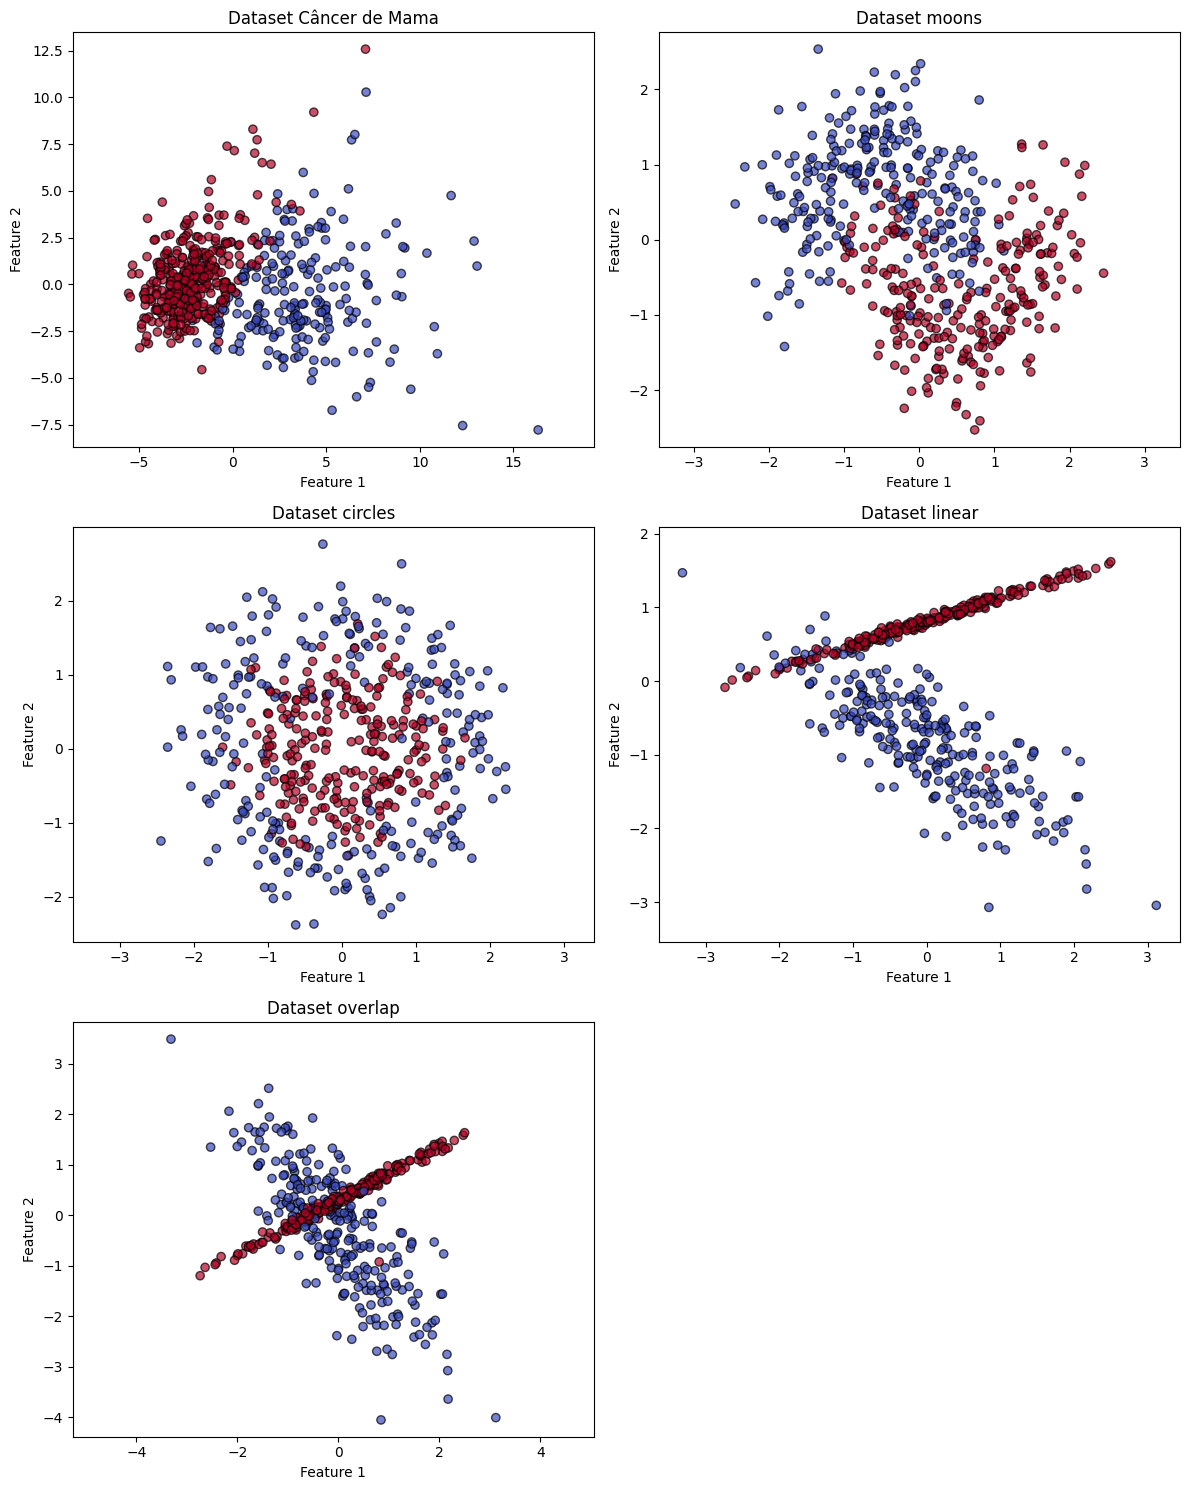

In [91]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15)) # 3 linhas, 2 colunas
axes = axes.flatten() # Facilita a iteração

dataset_names = list(all_datasets.keys())

for i, ax in enumerate(axes):
    if i < len(dataset_names): # Plotar apenas nos 5 primeiros eixos
        dataset_name = dataset_names[i]
        X, y = all_datasets[dataset_name]
        
        ax.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k', alpha=0.7)
        ax.set_title(f'Dataset {dataset_name}')
        if 'PCA' in dataset_name:
            ax.set_xlabel('PC1')
            ax.set_ylabel('PC2')
        else:
            ax.set_xlabel('Feature 1')
            ax.set_ylabel('Feature 2')
        ax.axis('equal') # Mantém a proporção dos eixos
    else:
        ax.axis('off') # Desliga o último eixo vazio

plt.tight_layout() # Ajusta o espaçamento
plt.show()

## Estratégia de Avaliação

Cada metodologia foi avaliada em relação à acurácia obtida e ao tempo necessário para encontrar os hiperparâmetros ideais (`k` e `h`). Também foi estabelecida uma linha de base (baseline), utilizando valores arbitrariamente ruins de hiperparâmetros (`k=1`, `h=1e-5`), com o intuito de identificar se o dataset é trivial (altamente previsível mesmo com parâmetros ruins) ou se os ganhos com a otimização são significativos.


In [100]:
all_results_list = []

for dataset_name, (X, y) in all_datasets.items():
    print(f"\nProcessando Dataset: {dataset_name}")
    dataset_results = {'Dataset': dataset_name}

    # 1. Baseline (k=1, h=1e-5)
    try:
        start = time.time()
        baseline_eval_accs = evaluate_best_individual(X, y, {'k': 1, 'h': 1e-5})
        dataset_results['Baseline Tempo'] = time.time() - start
        dataset_results['Baseline Acurácia'] = np.mean(baseline_eval_accs)
    except Exception as e:
        dataset_results['Baseline Tempo'] = np.nan
        dataset_results['Baseline Acurácia'] = np.nan

    # 2. Grid Search
    try:
        start = time.time()
        best_params_grid = run_grid_search(X, y, n_repeticoes=5)
        grid_time = time.time() - start
        grid_eval_accs = evaluate_best_individual(X, y, best_params_grid)
        dataset_results['Grid Search Tempo'] = grid_time
        dataset_results['Grid Search Acurácia'] = np.mean(grid_eval_accs)
    except Exception as e:
        dataset_results['Grid Search Tempo'] = np.nan
        dataset_results['Grid Search Acurácia'] = np.nan

    # 3. GA
    try:
        start = time.time()
        best_ga = run_ga(X, y, pop_size=30, n_generations=10)
        ga_time = time.time() - start
        ga_eval_accs = evaluate_best_individual(X, y, best_ga)
        dataset_results['GA Tempo'] = ga_time
        dataset_results['GA Acurácia'] = np.mean(ga_eval_accs)
    except Exception as e:
        dataset_results['GA Tempo'] = np.nan
        dataset_results['GA Acurácia'] = np.nan

    # 4. Centróide
    try:
        start = time.time()
        best_k, best_h = optimize_centroid_distance(X, y)
        centroid_time = time.time() - start
        centroid_eval_accs = evaluate_best_individual(X, y, {'k': best_k, 'h': best_h})
        dataset_results['Centróide Tempo'] = centroid_time
        dataset_results['Centróide Acurácia'] = np.mean(centroid_eval_accs)
    except Exception as e:
        dataset_results['Centróide Tempo'] = np.nan
        dataset_results['Centróide Acurácia'] = np.nan

    all_results_list.append(dataset_results)

df_final = pd.DataFrame(all_results_list)

column_order = ['Dataset']
methods = ['Baseline', 'Grid Search', 'GA', 'Centróide']
for method in methods:
    column_order.append(f'{method} Tempo')
    column_order.append(f'{method} Acurácia')

existing_columns = [col for col in column_order if col in df_final.columns]
df_final = df_final[existing_columns]


Processando Dataset: Câncer de Mama
Acurácias: [0.2982 0.2632 0.2632 0.2632 0.2719]
Média: 0.2719 | Desvio: 0.0136
Grid search: 32 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 6400


Rep 1/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Acurácias: [0.9211 0.9123 0.9386 0.9386 0.9211]
Média: 0.9263 | Desvio: 0.0105


Geração: 100%|██████████| 10/10 [00:15<00:00,  1.56s/it]



Melhor indivíduo: {'k': 65, 'h': 0.02315825769988508} Acurácia média (CV): 0.9737
Acurácias: [0.9561 0.9474 0.9035 0.9123 0.9561]
Média: 0.9351 | Desvio: 0.0226
Acurácias: [0.9561 0.9298 0.9298 0.9474 0.9474]
Média: 0.9421 | Desvio: 0.0105

Processando Dataset: moons
Acurácias: [0.66 0.48 0.58 0.56 0.64]
Média: 0.5840 | Desvio: 0.0637
Grid search: 32 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 6400


Rep 1/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Acurácias: [0.92 0.9  0.88 0.93 0.91]
Média: 0.9080 | Desvio: 0.0172


Geração: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]



Melhor indivíduo: {'k': 65, 'h': 0.02444754724726473} Acurácia média (CV): 0.9737
Acurácias: [0.94 0.91 0.9  0.92 0.93]
Média: 0.9200 | Desvio: 0.0141
Acurácias: [0.88 0.93 0.94 0.98 0.92]
Média: 0.9300 | Desvio: 0.0322

Processando Dataset: circles
Acurácias: [0.57 0.64 0.64 0.58 0.57]
Média: 0.6000 | Desvio: 0.0329
Grid search: 32 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 6400


Rep 1/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Acurácias: [0.93 0.91 0.86 0.87 0.84]
Média: 0.8820 | Desvio: 0.0331


Geração: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]



Melhor indivíduo: {'k': 52, 'h': 0.02193696137571797} Acurácia média (CV): 0.9737
Acurácias: [0.89 0.91 0.87 0.88 0.87]
Média: 0.8840 | Desvio: 0.0150
Acurácias: [0.87 0.88 0.88 0.88 0.89]
Média: 0.8800 | Desvio: 0.0063

Processando Dataset: linear
Acurácias: [0.86 0.82 0.83 0.84 0.76]
Média: 0.8220 | Desvio: 0.0337
Grid search: 32 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 6400


Rep 1/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Acurácias: [0.95 0.96 0.94 0.96 0.96]
Média: 0.9540 | Desvio: 0.0080


Geração: 100%|██████████| 10/10 [00:20<00:00,  2.02s/it]



Melhor indivíduo: {'k': 227, 'h': 0.0008499859846090155} Acurácia média (CV): 0.9750
Acurácias: [0.97 0.93 0.98 0.98 0.95]
Média: 0.9620 | Desvio: 0.0194
Acurácias: [0.96 0.98 0.96 0.96 0.92]
Média: 0.9560 | Desvio: 0.0196

Processando Dataset: overlap
Acurácias: [0.82 0.81 0.76 0.73 0.8 ]
Média: 0.7840 | Desvio: 0.0338
Grid search: 32 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 6400


Rep 1/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/32 [00:00<?, ?it/s]

Acurácias: [0.97 0.95 0.91 0.91 0.95]
Média: 0.9380 | Desvio: 0.0240


Geração: 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]



Melhor indivíduo: {'k': 5, 'h': 0.0012419887072831295} Acurácia média (CV): 0.9750
Acurácias: [0.96 0.92 0.96 0.95 0.99]
Média: 0.9560 | Desvio: 0.0224
Acurácias: [0.95 0.96 0.92 0.94 0.96]
Média: 0.9460 | Desvio: 0.0150


In [101]:
# 1. Definir 'Dataset' como índice (opcional, mas recomendado)
df_final = df_final.set_index('Dataset')

# 2. Criar tuplas para o MultiIndex a partir dos nomes das colunas existentes
# Exemplo: 'Baseline Tempo' -> ('Baseline', 'Tempo')
new_columns = []
for col in df_final.columns:
    parts = col.split(' ') # Divide o nome da coluna (ex: "Baseline Tempo")
    method_name = ' '.join(parts[:-1]) # Junta tudo menos a última parte (ex: "Baseline")
    metric_name = parts[-1] # Pega a última parte (ex: "Tempo" ou "Acurácia")
    new_columns.append((method_name, metric_name))

# 3. Criar o MultiIndex
multi_index = pd.MultiIndex.from_tuples(new_columns, names=['Método', 'Métrica'])

# 4. Atribuir o novo MultiIndex às colunas do DataFrame
df_final.columns = multi_index

## Resultados

Os experimentos foram executados em todos os datasets e os seguintes métodos foram aplicados:

- **Baseline**: referência com parâmetros ruins  
- **Grid Search**: combinação exaustiva de valores de `k` e `h`  
- **Algoritmo Genético (GA)**: busca evolutiva com população e gerações definidas  
- **Distância entre Centróides (Projeção Q1xQ2)**: otimização direta do espaço de decisão  

Os resultados mostraram que a metodologia baseada na distância entre centróides no espaço projetado (Q1xQ2) apresentou acurácias comparáveis, e muitas vezes superiores, aos métodos tradicionais. Além disso, seu tempo de execução foi significativamente inferior — em muitos casos, ordens de magnitude mais rápido do que o grid search e o GA.


In [102]:
df_final

Método          Baseline          Grid Search                   GA            \
Métrica            Tempo Acurácia       Tempo  Acurácia      Tempo  Acurácia   
Dataset                                                                        
Câncer de Mama  0.012201  0.27193  471.606713  0.926316  16.515030  0.935088   
moons           0.008007  0.58400  426.835174  0.908000  17.527983  0.920000   
circles         0.008476  0.60000  435.355940  0.882000  18.346445  0.884000   
linear          0.008637  0.82200  421.601879  0.954000  22.300309  0.962000   
overlap         0.008381  0.78400  419.398413  0.938000  19.052029  0.956000   

Método         Centróide            
Métrica            Tempo  Acurácia  
Dataset                             
Câncer de Mama  0.395751  0.942105  
moons           0.401286  0.930000  
circles         0.346551  0.880000  
linear          0.367062  0.956000  
overlap         0.374358  0.946000

## Conclusão

A minimização da distância entre centróides no espaço Q1xQ2 demonstrou-se uma alternativa promissora para a otimização de hiperparâmetros em classificadores KNN. Além de eficiente, é consideravelmente mais rápida do que métodos tradicionais, o que é vantajoso em cenários com restrições de tempo ou recursos computacionais.

No artigo final, esses resultados serão organizados formalmente com análises estatísticas e gráficos comparativos. Também será avaliada a generalização da metodologia para outros conjuntos de dados e cenários mais complexos.

---

In [7]:
# Listar todos os arquivos
pasta = 'data/dados'
arquivos_mat = [f for f in os.listdir(pasta) if f.endswith('.mat')]

# Criar dicionário para agrupar arquivos pelo nome base
datasets_dict = {}
for arquivo in arquivos_mat:
    nome_base = '_'.join(arquivo.split('_')[:2])
    if nome_base not in datasets_dict:
        datasets_dict[nome_base] = []
    datasets_dict[nome_base].append(arquivo)

# Pegar apenas o arquivo que termina com _1.mat de cada dataset
arquivos_selecionados = []
for nome_base, arquivos in datasets_dict.items():
    arquivo_1 = [f for f in arquivos if f.endswith('_1.mat')]
    if arquivo_1:  # se encontrou arquivo terminando com _1.mat
        arquivos_selecionados.append(arquivo_1[0])
    else:  # se não encontrou, pega o primeiro arquivo (fallback)
        arquivos_selecionados.append(arquivos[0])

# Preparar lista para armazenar informações
datasets_info = []

# Analisar cada dataset
for arquivo in tqdm(arquivos_selecionados, desc="Analisando datasets"):
    caminho_completo = os.path.join(pasta, arquivo)
    mat_data = scipy.io.loadmat(caminho_completo)
    X, y = mat_data['data'][0][0][0], mat_data['data'][0][0][1]
    
    # Calcular variância explicada do PCA
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X)
    var_explicada = pca.explained_variance_ratio_.sum()
    
    # Contar classes
    classes, contagens = np.unique(y, return_counts=True)
    balanceamento = dict(zip(classes, contagens))
    
    # Coletar informações
    info = {
        'Nome': '_'.join(arquivo.split('_')[:2]),
        'Arquivo_original': arquivo,
        'N_amostras': X.shape[0],
        'N_features_original': X.shape[1],
        'Classes_unicas': len(classes),
        'Balanceamento': str(balanceamento),
        'Var_explicada_PCA': f"{var_explicada*100:.2f}%",
        'Min_valor': float(X.min()),
        'Max_valor': float(X.max()),
        'Media': float(X.mean()),
        'Desvio_padrao': float(X.std())
    }
    datasets_info.append(info)

# Criar DataFrame
df_info = pd.DataFrame(datasets_info)

# Ordenar por número de amostras
df_info = df_info.sort_values('N_amostras', ascending=False)

Analisando datasets: 100%|██████████| 15/15 [00:00<00:00, 282.99it/s]


In [8]:
import os
import scipy.io
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Carregar apenas os datasets _1.mat
pasta = 'data/dados'
arquivos_mat = [f for f in os.listdir(pasta) if f.endswith('_1.mat')]
all_datasets = {}

# Carregar e reduzir dimensionalidade
for arquivo in tqdm(arquivos_mat, desc="Carregando datasets"):
    mat_data = scipy.io.loadmat(os.path.join(pasta, arquivo))
    nome_dataset = '_'.join(arquivo.split('_')[:2])
    X, y = mat_data['data'][0][0][0], mat_data['data'][0][0][1]
    
    # Reduzir para 2D e normalizar
    X_2d = PCA(n_components=2).fit_transform(X)
    X_2d = StandardScaler().fit_transform(X_2d)  # Adicionar normalização após PCA
    
    # Garantir que y seja 1D e valores sejam -1 ou 1
    y = y.flatten()
    y = np.where(y == 0, -1, y)  # Converter possíveis 0s para -1
    
    all_datasets[nome_dataset] = (X_2d, y)

Carregando datasets: 100%|██████████| 15/15 [00:00<00:00, 428.42it/s]


In [9]:

# Executar as avaliações
all_results_list = []

for dataset_name, (X, y) in tqdm(all_datasets.items(), desc="Processando datasets"):
    dataset_results = {'Dataset': dataset_name}

    # 1. Baseline
    start = time.time()
    baseline_eval_accs = evaluate_best_individual(X, y, {'k': 1, 'h': 1e-5})
    dataset_results['Baseline Tempo'] = time.time() - start
    dataset_results['Baseline Acurácia'] = np.mean(baseline_eval_accs)

    # 2. Grid Search
    start = time.time()
    best_params_grid = run_grid_search(X, y, n_repeticoes=5)
    grid_time = time.time() - start
    grid_eval_accs = evaluate_best_individual(X, y, best_params_grid)
    dataset_results['Grid Search Tempo'] = grid_time
    dataset_results['Grid Search Acurácia'] = np.mean(grid_eval_accs)

    # 3. GA
    start = time.time()
    best_ga = run_ga(X, y, pop_size=30, n_generations=10)
    ga_time = time.time() - start
    ga_eval_accs = evaluate_best_individual(X, y, best_ga)
    dataset_results['GA Tempo'] = ga_time
    dataset_results['GA Acurácia'] = np.mean(ga_eval_accs)

    # 4. Centróide
    start = time.time()
    best_k, best_h = optimize_centroid_distance(X, y)
    centroid_time = time.time() - start
    centroid_eval_accs = evaluate_best_individual(X, y, {'k': best_k, 'h': best_h})
    dataset_results['Centróide Tempo'] = centroid_time
    dataset_results['Centróide Acurácia'] = np.mean(centroid_eval_accs)

    all_results_list.append(dataset_results)

# Criar e organizar DataFrame final
df_final = pd.DataFrame(all_results_list)
column_order = ['Dataset'] + [f'{method} {metric}' 
                            for method in ['Baseline', 'Grid Search', 'GA', 'Centróide']
                            for metric in ['Tempo', 'Acurácia']]
df_final = df_final[column_order]
df_final.to_csv('resultados_completos.csv', index=False)

Processando datasets:   0%|          | 0/15 [00:00<?, ?it/s]

Acurácias: [0.5918 0.602  0.602  0.6122 0.551 ]
Média: 0.5918 | Desvio: 0.0214
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.9286 0.9184 0.9286 0.9184 0.8878]
Média: 0.9163 | Desvio: 0.0150


Geração: 100%|██████████| 10/10 [00:27<00:00,  2.80s/it]



Melhor indivíduo: {'k': 151, 'h': 0.7423149980177943} Acurácia média (CV): 0.9133
Acurácias: [0.8878 0.9184 0.9286 0.9388 0.9286]
Média: 0.9204 | Desvio: 0.0176


Processando datasets:   7%|▋         | 1/15 [13:14<3:05:25, 794.69s/it]

Acurácias: [0.8878 0.898  0.8878 0.9286 0.9286]
Média: 0.9061 | Desvio: 0.0187
Acurácias: [0.371  0.3226 0.2419 0.2903 0.3548]
Média: 0.3161 | Desvio: 0.0463
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.5968 0.629  0.6129 0.5    0.629 ]
Média: 0.5935 | Desvio: 0.0483


Geração: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]



Melhor indivíduo: {'k': 211, 'h': 1.9684194472866112} Acurácia média (CV): 0.9133
Acurácias: [0.629  0.5484 0.629  0.5806 0.629 ]
Média: 0.6032 | Desvio: 0.0332


Processando datasets:  13%|█▎        | 2/15 [21:36<2:14:52, 622.51s/it]

Acurácias: [0.5806 0.5645 0.5645 0.629  0.6452]
Média: 0.5968 | Desvio: 0.0338
Acurácias: [0.6095 0.6    0.6095 0.6286 0.6476]
Média: 0.6190 | Desvio: 0.0170
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.6952 0.7333 0.6857 0.6952 0.7048]
Média: 0.7029 | Desvio: 0.0164


Geração: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



Melhor indivíduo: {'k': 48, 'h': 3.293419547300958e-05} Acurácia média (CV): 0.8163
Acurácias: [0.6571 0.6286 0.5714 0.5905 0.6952]
Média: 0.6286 | Desvio: 0.0447


Processando datasets:  20%|██        | 3/15 [35:41<2:24:48, 724.03s/it]

Acurácias: [0.6286 0.6952 0.6857 0.6381 0.6   ]
Média: 0.6495 | Desvio: 0.0358
Acurácias: [0.5722 0.5889 0.6222 0.5944 0.5833]
Média: 0.5922 | Desvio: 0.0167
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.7444 0.7111 0.7222 0.7611 0.6778]
Média: 0.7233 | Desvio: 0.0286


Geração: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]



Melhor indivíduo: {'k': 217, 'h': 0.08973072494285637} Acurácia média (CV): 0.9133
Acurácias: [0.7222 0.6889 0.6944 0.6944 0.6833]
Média: 0.6967 | Desvio: 0.0134


Processando datasets:  27%|██▋       | 4/15 [1:04:18<3:24:35, 1115.96s/it]

Acurácias: [0.7278 0.7056 0.7056 0.6944 0.7389]
Média: 0.7144 | Desvio: 0.0163
Acurácias: [0.4182 0.4364 0.5455 0.4    0.5091]
Média: 0.4618 | Desvio: 0.0559
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.6545 0.7091 0.7455 0.6545 0.6545]
Média: 0.6836 | Desvio: 0.0374


Geração: 100%|██████████| 10/10 [00:15<00:00,  1.57s/it]



Melhor indivíduo: {'k': 168, 'h': 0.9219468447849992} Acurácia média (CV): 0.7472
Acurácias: [0.7818 0.6909 0.7636 0.7091 0.7091]
Média: 0.7309 | Desvio: 0.0353


Processando datasets:  33%|███▎      | 5/15 [1:13:10<2:30:56, 905.62s/it] 

Acurácias: [0.6727 0.8    0.6545 0.6909 0.6545]
Média: 0.6945 | Desvio: 0.0544
Acurácias: [0.1538 0.2308 0.3077 0.1538 0.3077]
Média: 0.2308 | Desvio: 0.0688
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.6923 0.5385 0.8462 0.7692 0.6154]
Média: 0.6923 | Desvio: 0.1088


Processando datasets:  40%|████      | 6/15 [1:14:36<1:34:00, 626.77s/it]


Melhor indivíduo: {'k': 26, 'h': 0.7423149980177943} Acurácia média (CV): 0.9133
Acurácias: [0.8462 0.6923 0.7692 0.6923 0.7692]
Média: 0.7538 | Desvio: 0.0576
Acurácias: [0.6923 0.7692 0.6154 0.6923 0.6923]
Média: 0.6923 | Desvio: 0.0487
Acurácias: [0.25   0.2778 0.3056 0.4167 0.3611]
Média: 0.3222 | Desvio: 0.0598
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.8611 0.8333 0.9444 0.8889 0.8056]
Média: 0.8667 | Desvio: 0.0478


Processando datasets:  47%|████▋     | 7/15 [1:19:42<1:09:34, 521.76s/it]


Melhor indivíduo: {'k': 135, 'h': 0.18147780986393233} Acurácia média (CV): 0.9133
Acurácias: [0.8333 0.8611 0.7778 0.7778 0.8333]
Média: 0.8167 | Desvio: 0.0333
Acurácias: [0.8333 0.9444 0.8056 0.8333 0.8889]
Média: 0.8611 | Desvio: 0.0497
Acurácias: [0.6939 0.6327 0.7755 0.7551 0.7347]
Média: 0.7184 | Desvio: 0.0507
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.6939 0.7755 0.7959 0.8571 0.8571]
Média: 0.7959 | Desvio: 0.0605


Processando datasets:  53%|█████▎    | 8/15 [1:26:25<56:28, 484.10s/it]  


Melhor indivíduo: {'k': 208, 'h': 0.013471370006941858} Acurácia média (CV): 0.8571
Acurácias: [0.7551 0.7755 0.8776 0.7143 0.8367]
Média: 0.7918 | Desvio: 0.0583
Acurácias: [0.7551 0.7347 0.7347 0.8163 0.7959]
Média: 0.7673 | Desvio: 0.0332
Acurácias: [0.824 0.784 0.856 0.8   0.856]
Média: 0.8240 | Desvio: 0.0291
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.872 0.856 0.896 0.864 0.824]
Média: 0.8624 | Desvio: 0.0234


Geração: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]



Melhor indivíduo: {'k': 125, 'h': 0.06482831084981072} Acurácia média (CV): 0.9040
Acurácias: [0.824 0.856 0.856 0.88  0.824]
Média: 0.8480 | Desvio: 0.0215


Processando datasets:  60%|██████    | 9/15 [1:44:31<1:07:13, 672.25s/it]

Acurácias: [0.872 0.84  0.888 0.832 0.816]
Média: 0.8496 | Desvio: 0.0265
Acurácias: [0.125  0.0833 0.2083 0.125  0.1667]
Média: 0.1417 | Desvio: 0.0425
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.7083 0.7083 0.8333 0.7917 0.8333]
Média: 0.7750 | Desvio: 0.0565


Processando datasets:  67%|██████▋   | 10/15 [1:47:47<43:46, 525.26s/it] 


Melhor indivíduo: {'k': 197, 'h': 0.48123027439974203} Acurácia média (CV): 0.8750
Acurácias: [0.6667 0.75   0.75   0.875  0.9167]
Média: 0.7917 | Desvio: 0.0913
Acurácias: [0.75   0.7917 0.7917 0.7917 0.8333]
Média: 0.7917 | Desvio: 0.0264
Acurácias: [0.3158 0.2632 0.2368 0.2632 0.2895]
Média: 0.2737 | Desvio: 0.0268
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.5    0.6053 0.5    0.5263 0.4474]
Média: 0.5158 | Desvio: 0.0516


Processando datasets:  73%|███████▎  | 11/15 [1:53:17<31:02, 465.60s/it]


Melhor indivíduo: {'k': 176, 'h': 0.5363048996942866} Acurácia média (CV): 0.9133
Acurácias: [0.6579 0.5263 0.5    0.5263 0.6316]
Média: 0.5684 | Desvio: 0.0636
Acurácias: [0.5    0.4211 0.5526 0.5    0.6316]
Média: 0.5211 | Desvio: 0.0694
Acurácias: [0.8537 0.7642 0.7805 0.8455 0.7724]
Média: 0.8033 | Desvio: 0.0383
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.9431 0.9593 0.9187 0.9675 0.9593]
Média: 0.9496 | Desvio: 0.0174


Geração: 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]



Melhor indivíduo: {'k': 25, 'h': 0.48123027439974203} Acurácia média (CV): 0.9715
Acurácias: [0.9837 1.     0.9756 0.9593 0.9675]
Média: 0.9772 | Desvio: 0.0140


Processando datasets:  80%|████████  | 12/15 [2:11:02<32:23, 647.84s/it]

Acurácias: [0.9593 0.9919 0.9837 0.9919 0.9756]
Média: 0.9805 | Desvio: 0.0122
Acurácias: [0.7222 0.7222 0.6111 0.6667 0.5556]
Média: 0.6556 | Desvio: 0.0648
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.8333 0.7222 0.7222 0.8889 0.8333]
Média: 0.8000 | Desvio: 0.0667


Processando datasets:  87%|████████▋ | 13/15 [2:13:13<16:22, 491.39s/it]


Melhor indivíduo: {'k': 145, 'h': 0.5363048996942866} Acurácia média (CV): 0.9133
Acurácias: [0.9444 0.8333 0.8889 0.8889 0.8889]
Média: 0.8889 | Desvio: 0.0351
Acurácias: [1.     0.8889 0.8889 0.8333 0.9444]
Média: 0.9111 | Desvio: 0.0567
Acurácias: [0.518  0.5036 0.5468 0.4748 0.518 ]
Média: 0.5122 | Desvio: 0.0234
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.7338 0.6978 0.7266 0.6978 0.6763]
Média: 0.7065 | Desvio: 0.0210


Geração: 100%|██████████| 10/10 [00:18<00:00,  1.86s/it]



Melhor indivíduo: {'k': 93, 'h': 0.14611872781107457} Acurácia média (CV): 0.9715
Acurácias: [0.7194 0.705  0.7266 0.7698 0.7842]
Média: 0.7410 | Desvio: 0.0305


Processando datasets:  93%|█████████▎| 14/15 [2:33:48<11:55, 715.96s/it]

Acurácias: [0.741  0.6978 0.7266 0.7554 0.7554]
Média: 0.7353 | Desvio: 0.0215
Acurácias: [0.8664 0.8138 0.8381 0.8259 0.8907]
Média: 0.8470 | Desvio: 0.0280
Grid search: 63 valores de k × 40 valores de h × 5 repetições
Total de avaliações: 12600


Rep 1/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 2/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 3/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 4/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Rep 5/5 - k:   0%|          | 0/63 [00:00<?, ?it/s]

Acurácias: [0.8947 0.9231 0.8785 0.9069 0.9028]
Média: 0.9012 | Desvio: 0.0146


Geração: 100%|██████████| 10/10 [00:54<00:00,  5.49s/it]



Melhor indivíduo: {'k': 105, 'h': 0.008272695874133698} Acurácia média (CV): 0.9675
Acurácias: [0.8907 0.8947 0.8543 0.9109 0.8583]
Média: 0.8818 | Desvio: 0.0219


Processando datasets: 100%|██████████| 15/15 [3:11:08<00:00, 764.59s/it] 

Acurácias: [0.8664 0.8826 0.9069 0.8664 0.8907]
Média: 0.8826 | Desvio: 0.0154


In [10]:
df_final

,Dataset,Baseline Tempo,Baseline Acurácia,Grid Search Tempo,Grid Search Acurácia,GA Tempo,GA Acurácia,Centróide Tempo,Centróide Acurácia
0,exportBase_climate,0.026407,0.591837,764.221872,0.916327,30.084484,0.920408,0.333670,0.906122
1,exportBase_bupa,0.003616,0.316129,481.582606,0.593548,20.186516,0.603226,0.196429,0.596774
2,exportBase_ILPD,0.008948,0.619048,829.563204,0.702857,14.849904,0.628571,0.389026,0.649524
3,exportBase_german,0.025691,0.592222,1663.811590,0.723333,52.023449,0.696667,0.846513,0.714444
4,exportBase_haberman,0.003678,0.461818,514.802292,0.683636,17.628303,0.730909,0.209287,0.694545
5,exportBase_golub,0.002908,0.230769,84.621507,0.692308,0.694477,0.753846,0.142807,0.692308
6,exportBase_parkinsons,0.003242,0.322222,300.218337,0.866667,5.224267,0.816667,0.109101,0.861111
7,exportBase_heart,0.002974,0.718367,389.704274,0.795918,13.580009,0.791837,0.164900,0.767347
8,exportBase_australian,0.012848,0.824000,1062.692772,0.862400,22.675966,0.848000,0.534124,0.849600
9,exportBase_breastHess,0.001694,0.141667,192.638575,0.775000,3.400236,0.791667,0.074751,0.791667


In [11]:
df = pd.read_csv('resultados_completos.csv')

In [16]:
(df['Centróide Acurácia']>df['Grid Search Acurácia']).mean()

np.float64(0.4666666666666667)

In [18]:
(df['Centróide Acurácia']>df['GA Acurácia']).mean()

np.float64(0.4666666666666667)

In [26]:
df.to_clipboard(index=False)

In [12]:
# Criando uma cópia do DataFrame original
df_formatado = df.copy()

# Colunas de tempo
colunas_tempo = ['Baseline Tempo', 'Grid Search Tempo', 'GA Tempo', 'Centróide Tempo']
# Colunas de acurácia
colunas_acuracia = ['Baseline Acurácia', 'Grid Search Acurácia', 'GA Acurácia', 'Centróide Acurácia']

# Formatando colunas de tempo com arredondamento condicional
for col in colunas_tempo:
    # Aplicando a lógica condicional: se > 1s, round(1), senão round(3)
    df_formatado[col] = df_formatado[col].apply(
        lambda x: f"{x:.1f} s" if x > 1 else f"{x:.3f} s"
    )

# Formatando colunas de acurácia (convertendo para percentual e adicionando "%")
for col in colunas_acuracia:
    df_formatado[col] = (df_formatado[col] * 100).round(1).astype(str) + "%"

In [26]:
df_formatado.to_clipboard(index=False)

In [32]:
df_formatado.sort_values('Centróide Acurácia', ascending=False)

,Dataset,Baseline Tempo,Baseline Acurácia,Grid Search Tempo,Grid Search Acurácia,GA Tempo,GA Acurácia,Centróide Tempo,Centróide Acurácia
11,exportBase_breastcancer,0.012 s,80.3%,1041.0 s,95.0%,23.0 s,97.7%,0.593 s,98.0%
12,exportBase_fertility,0.002 s,65.6%,128.9 s,80.0%,2.4 s,88.9%,0.058 s,91.1%
0,exportBase_climate,0.026 s,59.2%,764.2 s,91.6%,30.1 s,92.0%,0.334 s,90.6%
14,exportBase_banknote,0.046 s,84.7%,2181.6 s,90.1%,57.1 s,88.2%,1.2 s,88.3%
6,exportBase_parkinsons,0.003 s,32.2%,300.2 s,86.7%,5.2 s,81.7%,0.109 s,86.1%
8,exportBase_australian,0.013 s,82.4%,1062.7 s,86.2%,22.7 s,84.8%,0.534 s,85.0%
9,exportBase_breastHess,0.002 s,14.2%,192.6 s,77.5%,3.4 s,79.2%,0.075 s,79.2%
7,exportBase_heart,0.003 s,71.8%,389.7 s,79.6%,13.6 s,79.2%,0.165 s,76.7%
13,exportBase_diabetes,0.016 s,51.2%,1214.8 s,70.6%,19.4 s,74.1%,0.597 s,73.5%
3,exportBase_german,0.026 s,59.2%,1663.8 s,72.3%,52.0 s,69.7%,0.847 s,71.4%


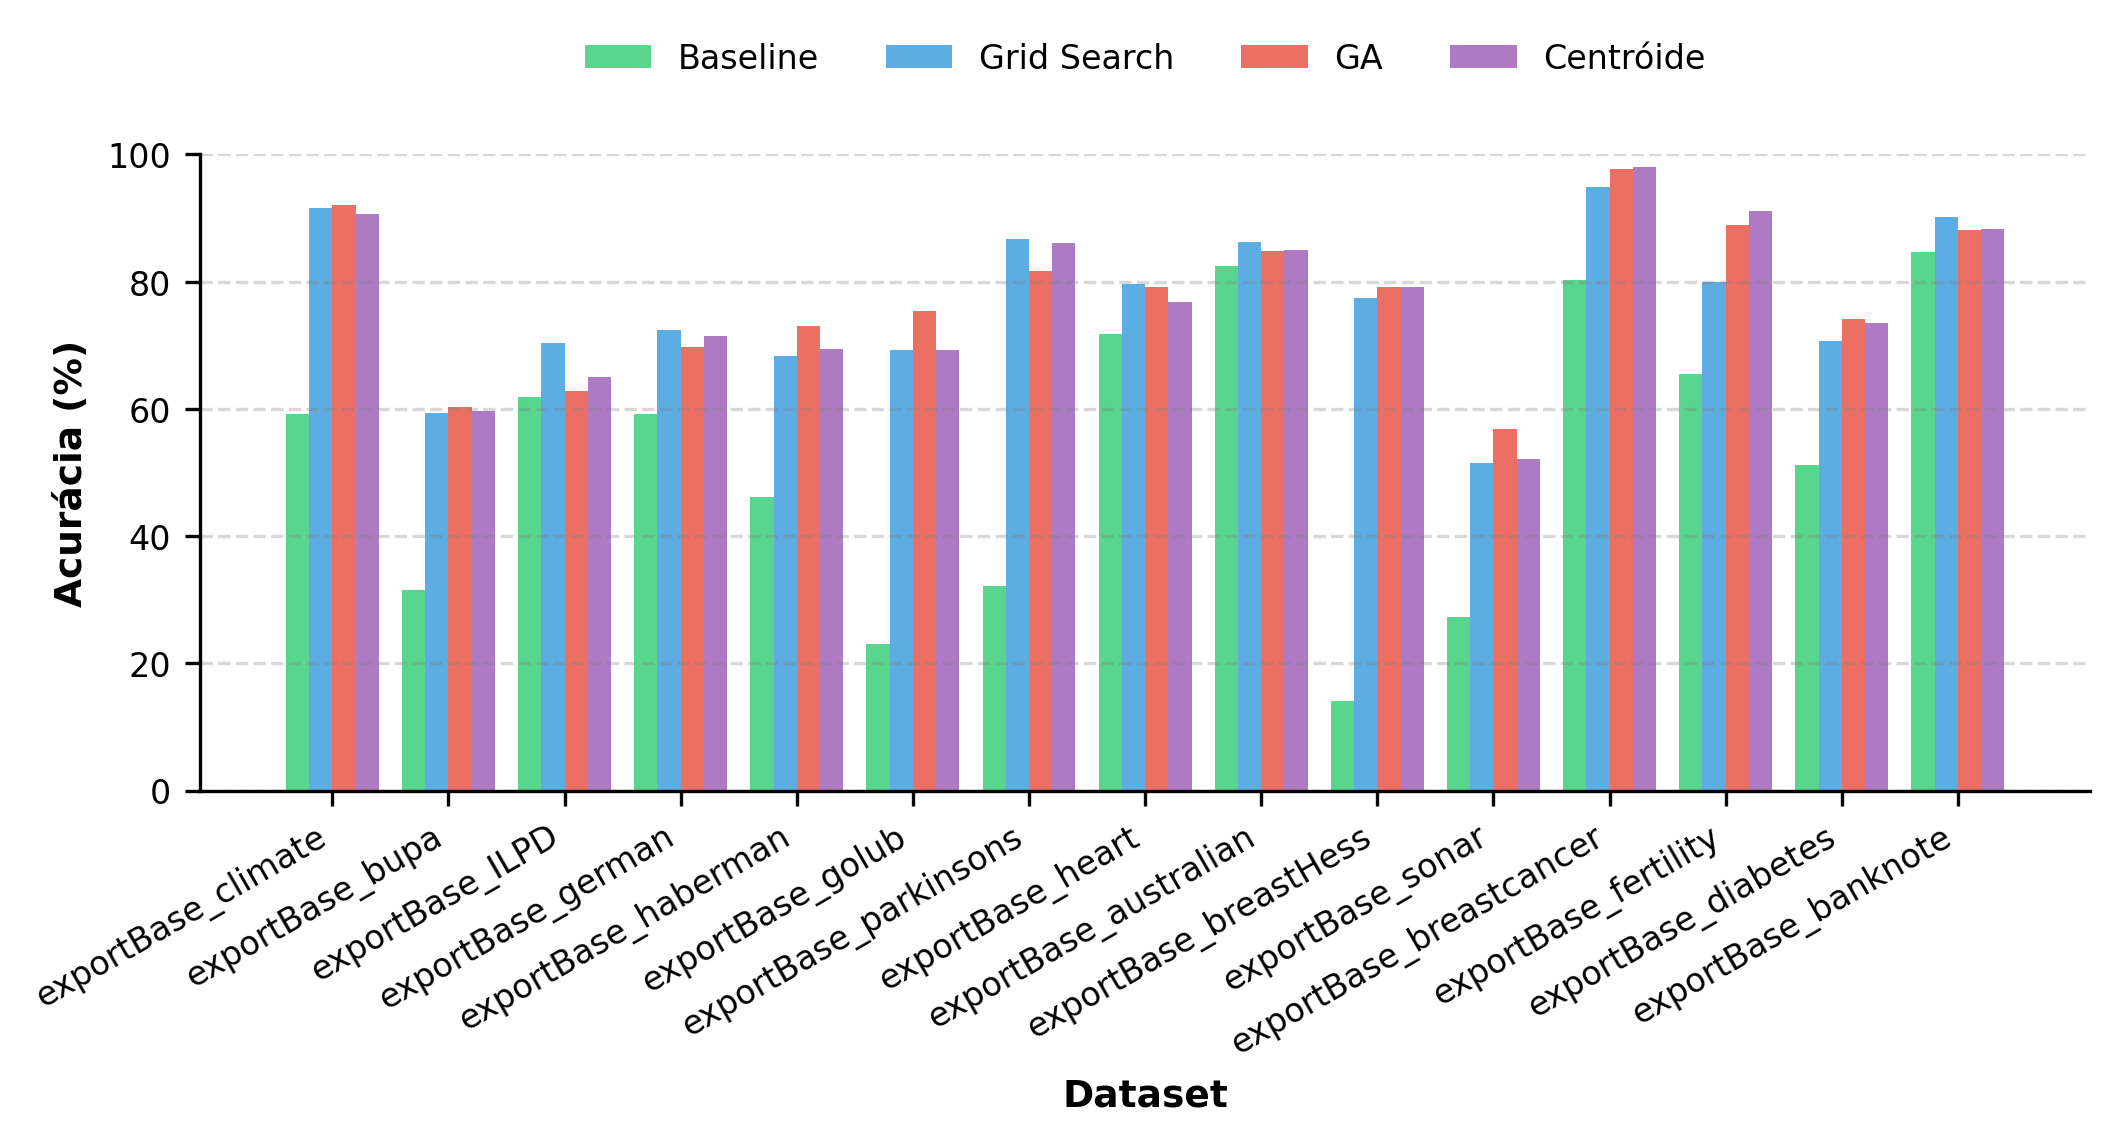

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Configurando o estilo para ser mais apropriado para publicações
plt.rcParams['font.family'] = 'DejaVu Sans'  # Fonte mais comum e compatível
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

# Criando a figura
fig, ax = plt.subplots(figsize=(7.16, 4), dpi=300)  # Aumentei um pouco a altura

# Preparando os dados
colunas_plot = ['Dataset', 'Baseline Acurácia', 'Grid Search Acurácia', 'GA Acurácia', 'Centróide Acurácia']
df_plot = df[colunas_plot].copy()

# Multiplicando por 100 para converter para percentual
for col in colunas_plot[1:]:
    df_plot[col] = df_plot[col] * 100

# Criando o gráfico de barras agrupadas
x = np.arange(len(df_plot['Dataset']))
width = 0.2

# Usando cores mais vibrantes mas ainda apropriadas para publicação
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']  # verde, azul, vermelho, roxo

ax.bar(x - 1.5*width, df_plot['Baseline Acurácia'], width, label='Baseline', 
       color=colors[0], alpha=0.8)
ax.bar(x - 0.5*width, df_plot['Grid Search Acurácia'], width, label='Grid Search', 
       color=colors[1], alpha=0.8)
ax.bar(x + 0.5*width, df_plot['GA Acurácia'], width, label='GA', 
       color=colors[2], alpha=0.8)
ax.bar(x + 1.5*width, df_plot['Centróide Acurácia'], width, label='Centróide', 
       color=colors[3], alpha=0.8)

# Personalizando o gráfico
ax.set_xlabel('Dataset', fontweight='bold')
ax.set_ylabel('Acurácia (%)', fontweight='bold')

# Rotacionando os labels do eixo x
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Dataset'], rotation=30, ha='right')

# Ajustando os limites do eixo y
ax.set_ylim(0, 100)

# Grid mais sutil
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')

# Posicionando a legenda
ax.legend(ncol=4, bbox_to_anchor=(0.5, 1.15), loc='center', frameon=False)

# Removendo as bordas do topo e direita
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustando o layout
plt.tight_layout()


# Salvando em alta resolução
# plt.savefig('accuracy_comparison.pdf', bbox_inches='tight', dpi=300)
plt.savefig('imagens/accuracy_comparison.png', bbox_inches='tight', dpi=300)

# Mostrando o gráfico
plt.show()

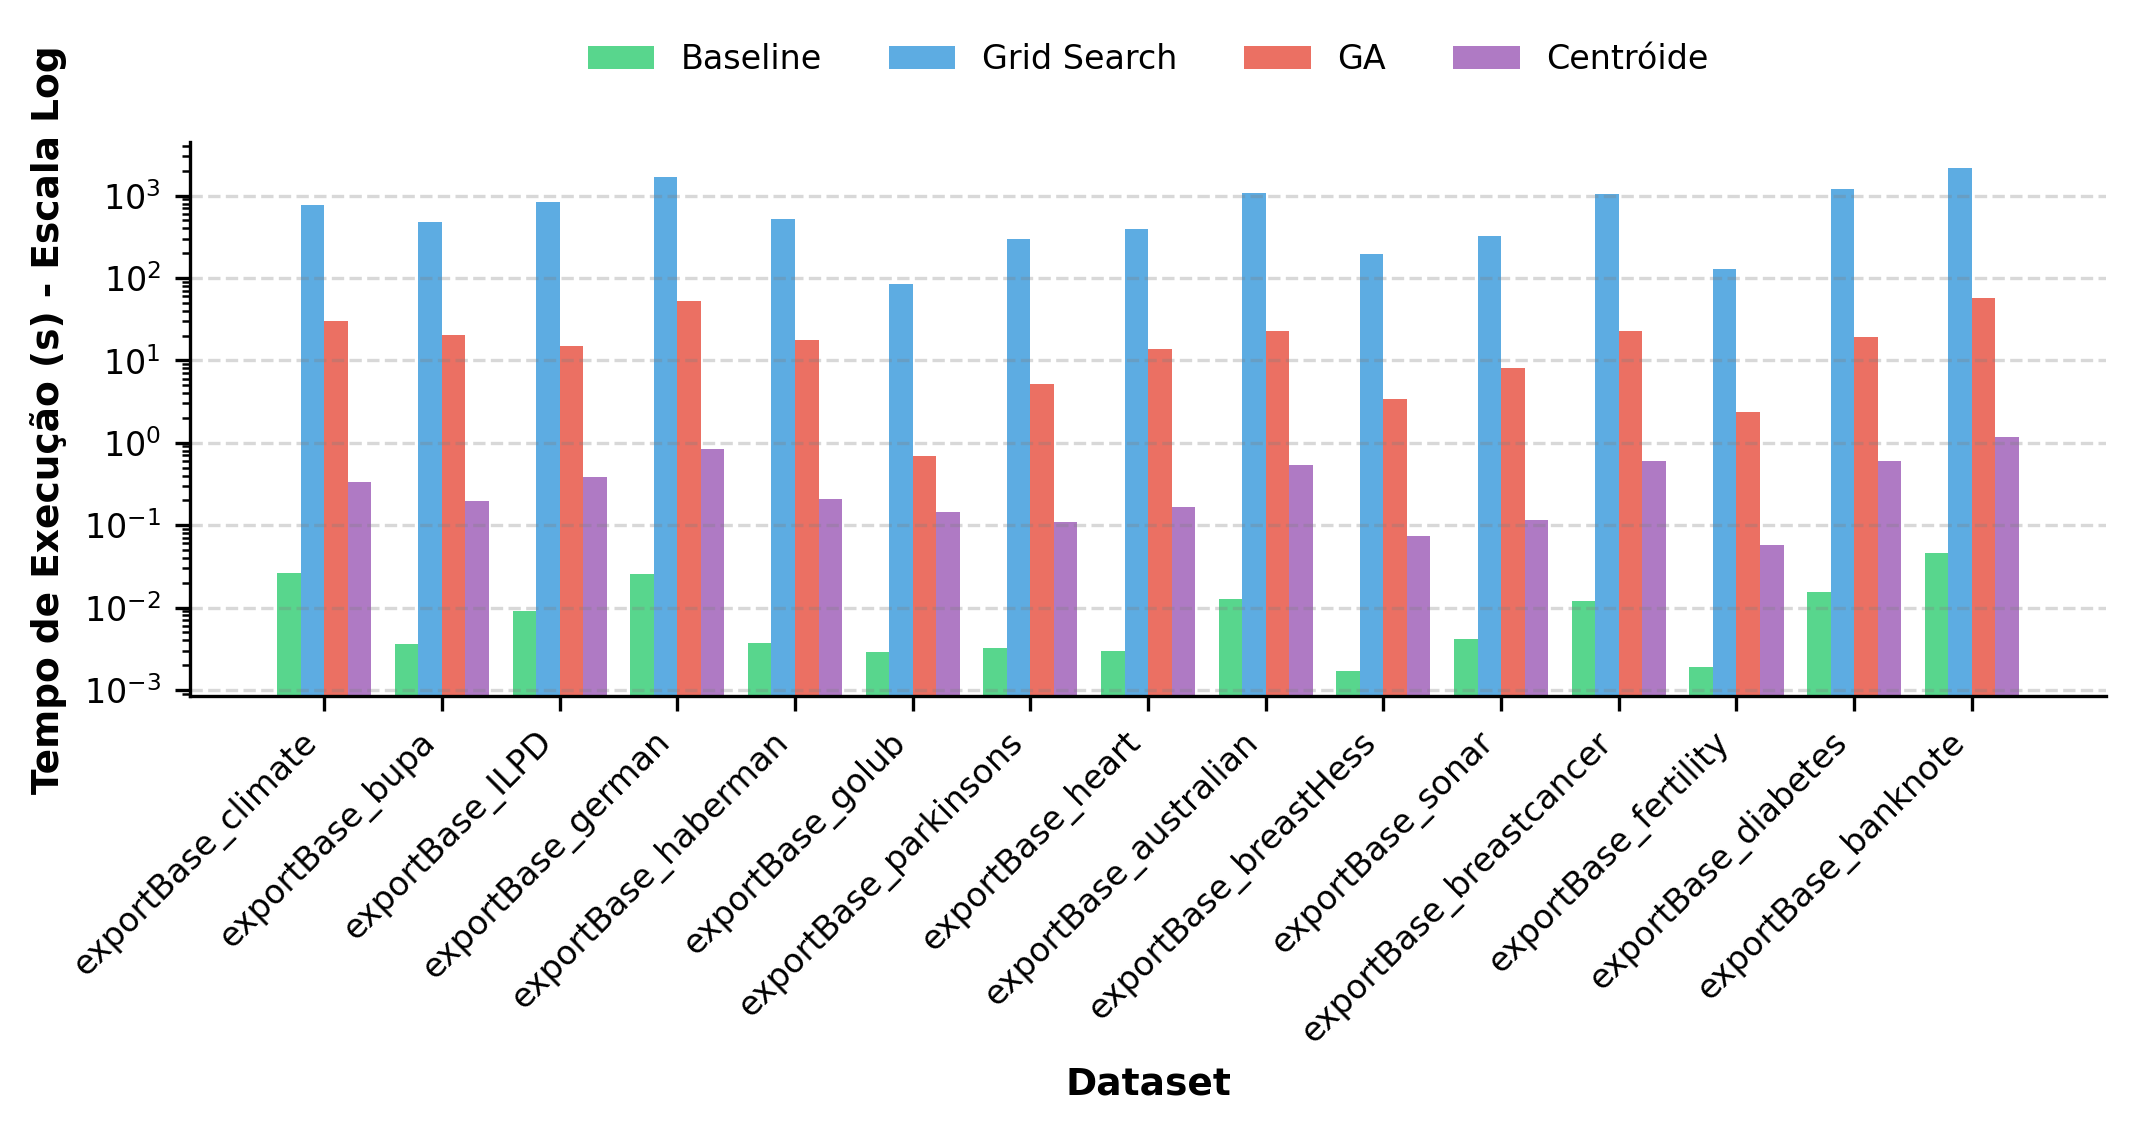

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Configurando o estilo para ser mais apropriado para publicações
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

# Criando a figura
fig, ax = plt.subplots(figsize=(7.16, 4), dpi=300)

# Preparando os dados
colunas_plot = ['Dataset', 'Baseline Tempo', 'Grid Search Tempo', 'GA Tempo', 'Centróide Tempo']
df_plot = df[colunas_plot].copy()

# Criando o gráfico de barras agrupadas
x = np.arange(len(df_plot['Dataset']))
width = 0.2

# Usando as mesmas cores do gráfico anterior
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']  # verde, azul, vermelho, roxo

# Plotando as barras
ax.bar(x - 1.5*width, df_plot['Baseline Tempo'], width, label='Baseline', 
       color=colors[0], alpha=0.8)
ax.bar(x - 0.5*width, df_plot['Grid Search Tempo'], width, label='Grid Search', 
       color=colors[1], alpha=0.8)
ax.bar(x + 0.5*width, df_plot['GA Tempo'], width, label='GA', 
       color=colors[2], alpha=0.8)
ax.bar(x + 1.5*width, df_plot['Centróide Tempo'], width, label='Centróide', 
       color=colors[3], alpha=0.8)

# Configurando escala logarítmica no eixo Y
ax.set_yscale('log')

# Personalizando o gráfico
ax.set_xlabel('Dataset', fontweight='bold')
ax.set_ylabel('Tempo de Execução (s) - Escala Log', fontweight='bold')

# Rotacionando os labels do eixo x
ax.set_xticks(x)
ax.set_xticklabels(df_plot['Dataset'], rotation=45, ha='right')

# Grid mais sutil (apenas para as linhas horizontais)
ax.yaxis.grid(True, linestyle='--', alpha=0.3, color='gray')

# Posicionando a legenda
ax.legend(ncol=4, bbox_to_anchor=(0.5, 1.15), loc='center', frameon=False)

# Removendo as bordas do topo e direita
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustando o layout
plt.tight_layout()

# Salvando em alta resolução
plt.savefig('imagens/execution_time_comparison_log.png', bbox_inches='tight', dpi=300)

# Mostrando o gráfico
plt.show()

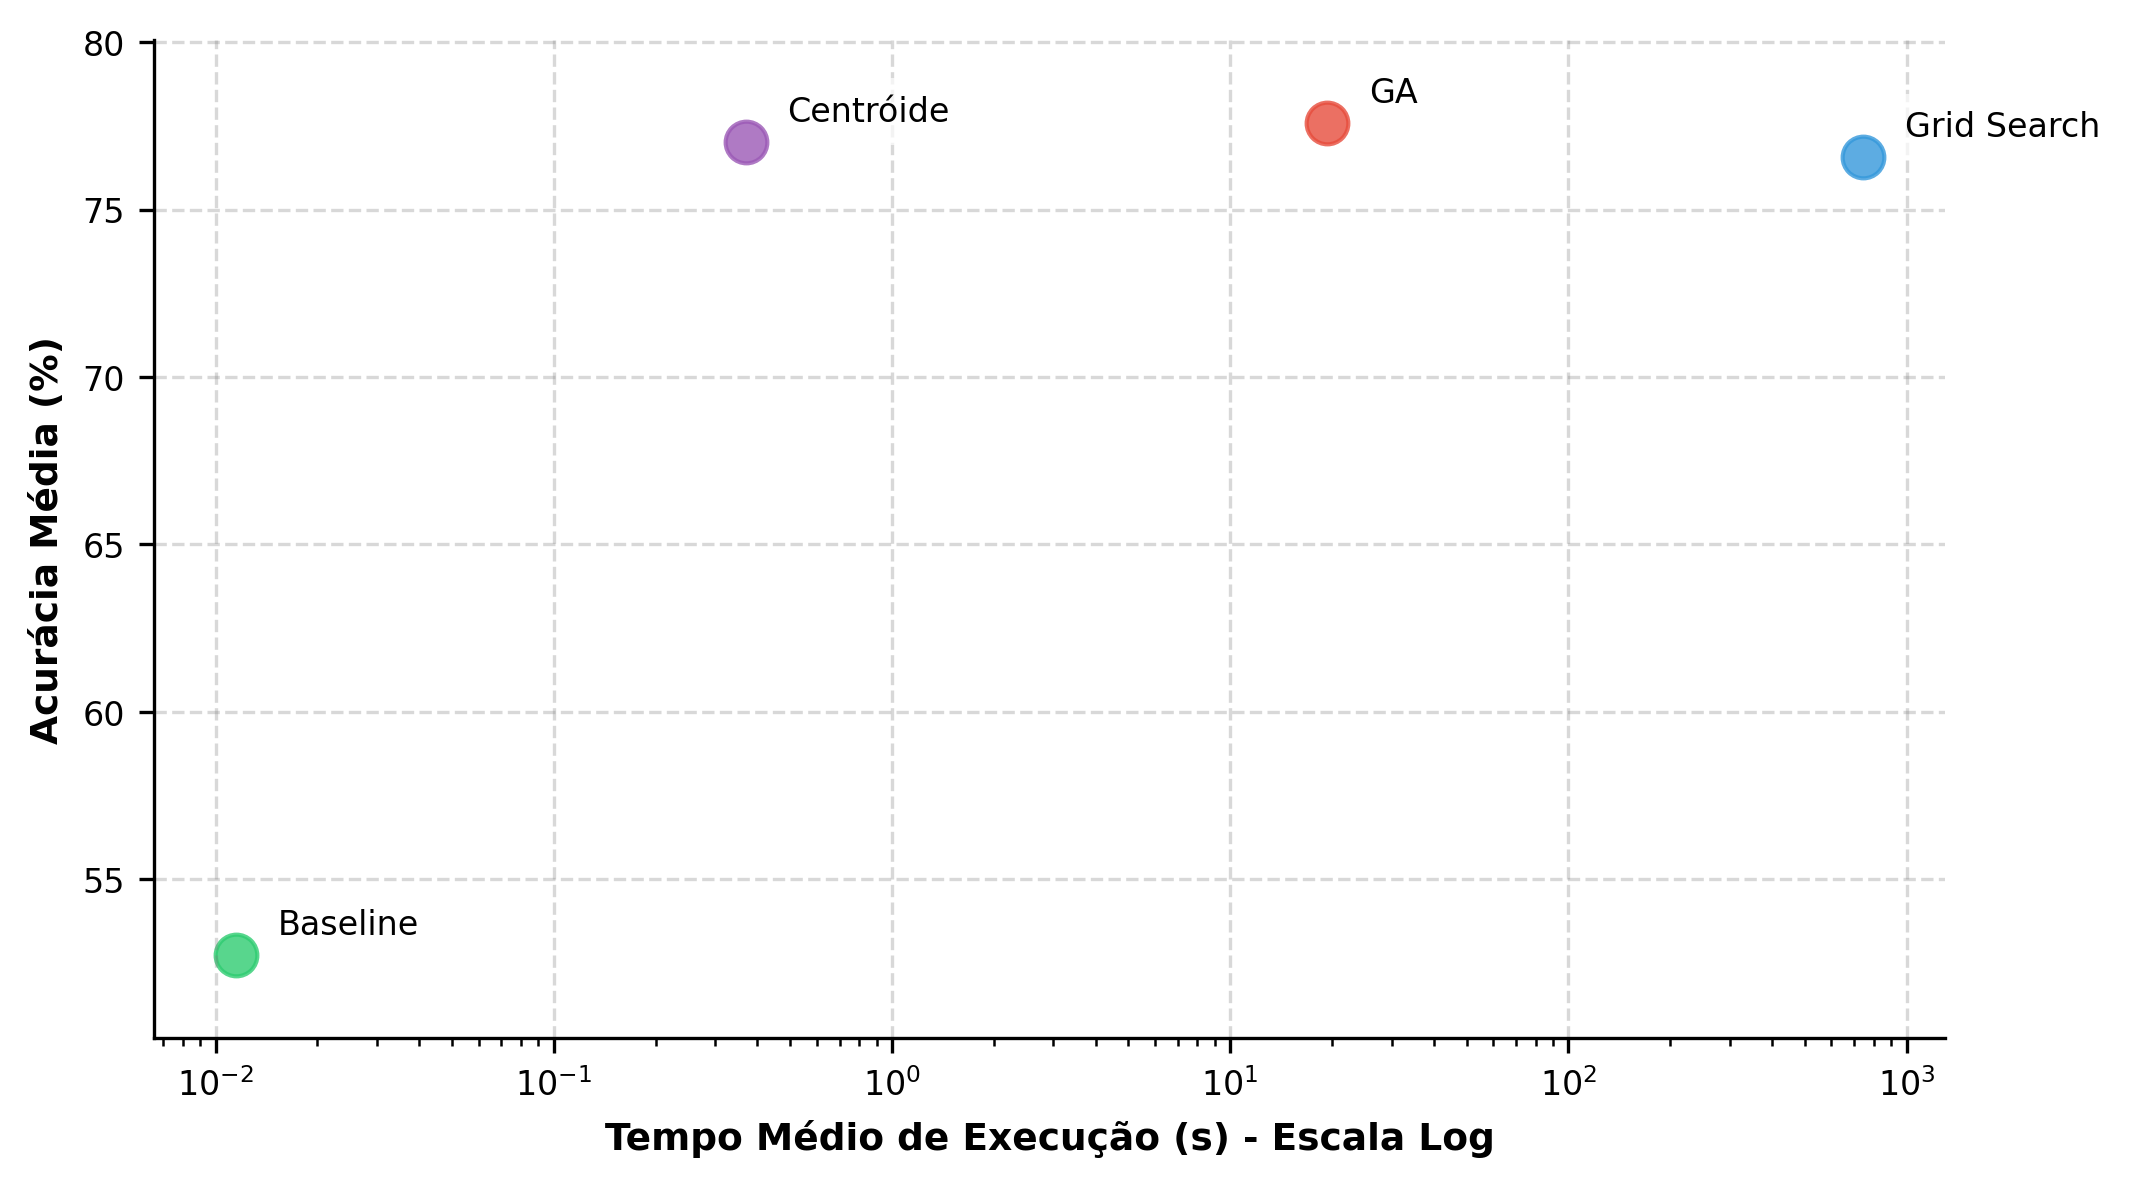

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Calculando as médias
metodos = {
    'Baseline': ('Baseline Tempo', 'Baseline Acurácia'),
    'Grid Search': ('Grid Search Tempo', 'Grid Search Acurácia'),
    'GA': ('GA Tempo', 'GA Acurácia'),
    'Centróide': ('Centróide Tempo', 'Centróide Acurácia')
}

# Calculando médias de tempo e acurácia para cada método
medias = {
    nome: (df[tempo_col].mean(), df[acc_col].mean() * 100)  # convertendo acurácia para percentual
    for nome, (tempo_col, acc_col) in metodos.items()
}

# Configurando o estilo
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8

# Criando a figura
fig, ax = plt.subplots(figsize=(7.16, 4), dpi=300)

# Cores consistentes com os gráficos anteriores
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

# Plotando os pontos
for (nome, (tempo, acc)), cor in zip(medias.items(), colors):
    ax.scatter(tempo, acc, c=[cor], s=100, alpha=0.8, label=nome)
    # Adicionando labels com pequeno offset
    ax.annotate(nome, 
                (tempo, acc),
                xytext=(10, 5),
                textcoords='offset points',
                fontsize=8,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Configurando escala logarítmica no eixo X
ax.set_xscale('log')

# Personalizando o gráfico
ax.set_xlabel('Tempo Médio de Execução (s) - Escala Log', fontweight='bold')
ax.set_ylabel('Acurácia Média (%)', fontweight='bold')

# Grid mais sutil
ax.grid(True, linestyle='--', alpha=0.3, color='gray')

# Removendo as bordas do topo e direita
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustando os limites do eixo Y para começar um pouco abaixo do menor valor
y_min = min(acc for _, acc in medias.values())
y_max = max(acc for _, acc in medias.values())
margin = (y_max - y_min) * 0.1
ax.set_ylim(y_min - margin, y_max + margin)

# Ajustando o layout
plt.tight_layout()

# Salvando em alta resolução
plt.savefig('imagens/time_accuracy_tradeoff.png', bbox_inches='tight', dpi=300)

# Mostrando o gráfico
plt.show()

In [29]:
df

,Dataset,Baseline Tempo,Baseline Acurácia,Grid Search Tempo,Grid Search Acurácia,GA Tempo,GA Acurácia,Centróide Tempo,Centróide Acurácia
0,exportBase_climate,0.019729,0.579592,410.970852,0.904082,30.701226,0.904082,0.373337,0.940816
1,exportBase_bupa,0.003945,0.303226,264.733289,0.551613,14.976922,0.545161,0.220011,0.632258
2,exportBase_ILPD,0.027772,0.662857,427.172741,0.708571,25.122082,0.720000,0.384562,0.670476
3,exportBase_german,0.026755,0.587778,749.151922,0.701111,36.525138,0.717778,0.737205,0.702222
4,exportBase_haberman,0.003534,0.447273,219.537631,0.650909,6.388702,0.680000,0.175345,0.705455
5,exportBase_golub,0.001197,0.200000,33.848158,0.615385,0.732315,0.753846,0.039732,0.738462
6,exportBase_parkinsons,0.002314,0.322222,140.528822,0.833333,7.492267,0.861111,0.105567,0.855556
7,exportBase_heart,0.002908,0.685714,188.791473,0.763265,12.114953,0.555102,0.157848,0.779592
8,exportBase_australian,0.012375,0.798400,551.235198,0.840000,27.000452,0.846400,0.463599,0.867200
9,exportBase_breastHess,0.001729,0.150000,99.473468,0.758333,3.668973,0.808333,0.079450,0.808333


In [87]:
(df['Centróide Acurácia']>df['Grid Search Acurácia']).mean()

np.float64(0.8)

In [89]:
(df['Centróide Acurácia']>df['GA Acurácia']).mean()

np.float64(0.5333333333333333)

In [78]:
df['Grid Search Tempo'] = df['Grid Search Tempo']*5

In [84]:
df.to_csv('resultados_completos_editado.csv', index=False)